# McDonald's Reviews RNN Model by Marshall Folkman

## Github Link
https://github.com/Vamboozer/AI/tree/afbf246e7bf4c27ce401b7d15d78cfe35a427206/DeepLearning/McDonald_s_Reviews

## Problem Description

### Problem Statement
The era of digitalization has transformed the way businesses gather feedback about their services and products. Online reviews provide an indispensable tool to gauge consumer satisfaction and sentiments. In the fast-food industry, especially with brands having widespread chains like McDonald's, understanding customer opinions becomes vital to sustain quality and service standards. However, manually analyzing tens of thousands of reviews to derive insights is infeasible. This project addresses the challenge of predicting customer satisfaction based on online reviews, specifically focusing on McDonald's stores in the United States.

### Objective
The primary objective of this project is to develop a Recurrent Neural Network (RNN) model that can predict the rating (number of stars) a customer might give based on their review text. This involves not only considering the textual content of the review but also other relevant features from the dataset to enhance prediction accuracy.

### Dataset Overview
The dataset for this project is sourced from Kaggle and contains over 33,000 anonymized reviews of McDonald's stores across the United States, scraped from Google reviews. It offers a comprehensive view of customer experiences and opinions on various aspects of McDonald's services.

https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews

#### Key Features:
| Feature         | Description                                                                   |
|-----------------|-------------------------------------------------------------------------------|
| **reviewer_id** | Anonymized unique identifier for each reviewer.                               |
| **store_name**  | Name of the McDonald's store.                                                 |
| **category**    | Category or type of the store.                                                |
| **store_address**| Physical address of the store.                                                |
| **latitude, longitude**| Geographical coordinates of the store's location.                        |
| **rating_count**| Number of ratings/reviews for the store.                                      |
| **review_time** | Timestamp of when the review was posted.                                      |
| **review**      | Textual content of the review.                                                |
| **rating**      | Rating provided by the reviewer, the target variable for our prediction model.|


## EDA & Cleaning

In [39]:
# Requires: pip install pandas matplotlib seaborn tensorflow scikit-learn nltk gensim nbconvert dateparser
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
print(sys.version)
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import Counter
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#!pip install keras-tuner
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, GRU, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam
from gensim.models import KeyedVectors
#!pip install dateparser
import dateparser
from dateutil.relativedelta import relativedelta
import re
import pytz

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
## ONLY RUN THIS CODE IF RUN FROM LOCAL MACHINE
#filename = 'D:\OneDrive\_CU-MSEE\AI\DTSA5511_DeepLearning\Week4\GoogleNews-vectors-negative300.bin'  # path to the Word2Vec file
#DatasetPath = 'D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/FinalProject/McDonald_s_Reviews.csv'

In [3]:
## ONLY RUN THIS CODE IF RUN FROM GOOGLE COLABORATORY
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

filename = '/content/drive/My Drive/Colab Notebooks/DeepLearningFinal_McDonaldsReviews/GoogleNews-vectors-negative300.bin'  # path to the Word2Vec file
DatasetPath = '/content/drive/My Drive/Colab Notebooks/DeepLearningFinal_McDonaldsReviews/McDonald_s_Reviews.csv'

Mounted at /content/drive


In [4]:
# load the google word2vec model
word2vec_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [5]:
data = pd.read_csv(DatasetPath, encoding='ISO-8859-1')
print(data.head())

   reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   
2            3  McDonald's  Fast food restaurant   
3            4  McDonald's  Fast food restaurant   
4            5  McDonald's  Fast food restaurant   

                                       store_address   latitude  longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
2  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
3  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
4  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   
1        1,240    5 days ago   
2        1,240    5 days ago   
3        1,240   a month ago   
4        1,240  2 months ago   

                         

In [6]:
# Convert the rating from text format to numerical format
print("Before:")
print(data['rating'].head())

# Convert the 'rating' column to numerical form by extracting the first character
data['rating'] = data['rating'].apply(lambda x: int(x[0]))

# Check the first few rows to make sure the conversion worked
print("After:")
print(data['rating'].head())

Before:
0     1 star
1    4 stars
2     1 star
3    5 stars
4     1 star
Name: rating, dtype: object
After:
0    1
1    4
2    1
3    5
4    1
Name: rating, dtype: int64


In [7]:
# Show a summary of the DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.5+ MB
None


In [8]:
# Count of unique values in each column
for column in data.columns:
    print(f"{column}: {data[column].nunique()} unique values")

reviewer_id: 33396 unique values
store_name: 2 unique values
category: 1 unique values
store_address: 40 unique values
latitude: 39 unique values
longitude: 39 unique values
rating_count: 51 unique values
review_time: 39 unique values
review: 22285 unique values
rating: 5 unique values


In [9]:
# Remove useless, patternless, or redundant features from the dataset
data = data.drop(columns=['store_name', 'category', 'rating_count'])
print(data.head())

   reviewer_id                                      store_address   latitude  \
0            1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718   
1            2  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718   
2            3  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718   
3            4  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718   
4            5  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718   

   longitude   review_time                                             review  \
0 -97.792874  3 months ago  Why does it look like someone spit on my food?...   
1 -97.792874    5 days ago  It'd McDonalds. It is what it is as far as the...   
2 -97.792874    5 days ago  Made a mobile order got to the speaker and che...   
3 -97.792874   a month ago  My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...   
4 -97.792874  2 months ago  I repeat my order 3 times in the drive thru, a...   

   rating  
0       1  
1       

In [10]:
# Show any missing values
print(data.isnull().sum())

reviewer_id        0
store_address      0
latitude         660
longitude        660
review_time        0
review             0
rating             0
dtype: int64


### Target - 1-5 Stars Ratings

5    10274
1     9431
4     5787
3     4818
2     3086
Name: rating, dtype: int64
Probabilities:
 5    0.307642
1    0.282399
4    0.173284
3    0.144269
2    0.092406
Name: rating, dtype: float64


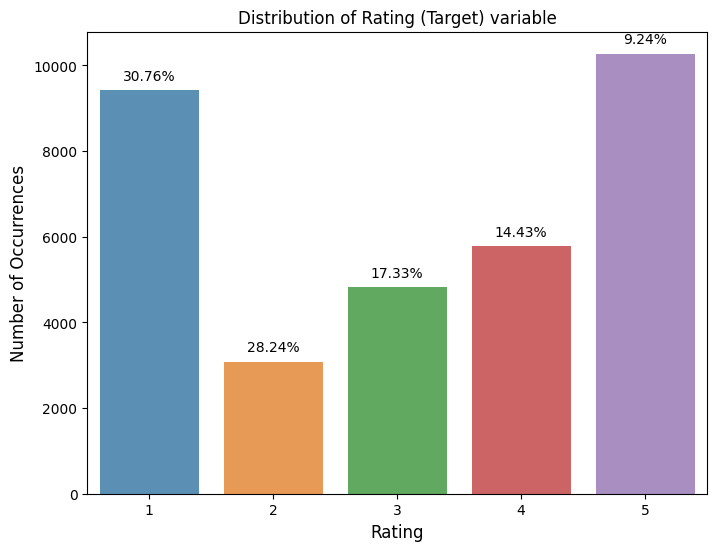

In [11]:
# Count the number of each target class
target_counts = data['rating'].value_counts()
print(target_counts)

# Calculating the probabilities
target_probabilities = target_counts / len(data)
print("Probabilities:\n", target_probabilities)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=target_counts.index, y=target_counts.values, alpha=0.8)
plt.title('Distribution of Rating (Target) variable')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Rating', fontsize=12)

# Adding the probabilities as annotations on the bars
for p, prob in zip(barplot.patches, target_probabilities.values):
    barplot.annotate(f'{prob:.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

### Review Text Analysis and Cleaning

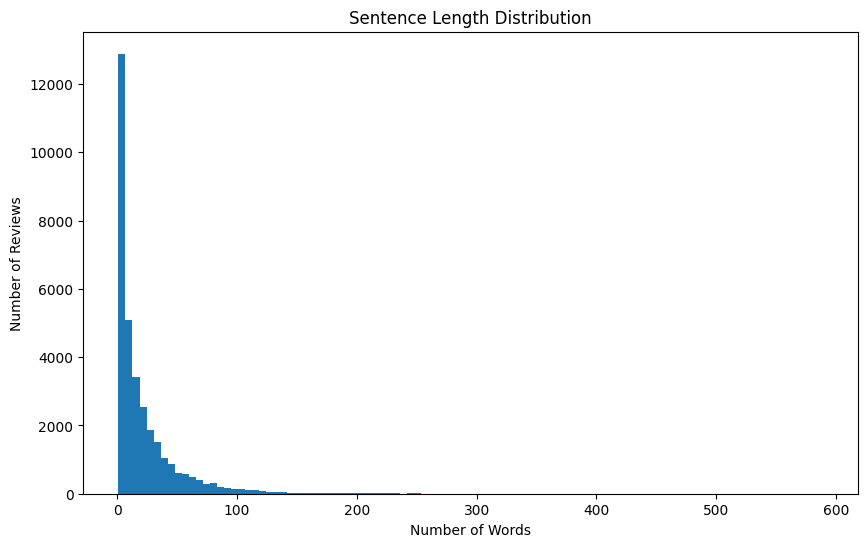

In [12]:
# Analyze sentence length
data['text_length'] = data['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=100)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.show()

In [13]:
# Count occurrences of each word
word_counts = Counter()
data['review'].str.split().apply(word_counts.update)

# Most common words
print("Most common words:", word_counts.most_common(10))

# Least common words
print("Least common words:", word_counts.most_common()[:-10:-1])

Most common words: [('the', 29217), ('and', 23494), ('to', 19112), ('I', 16343), ('a', 14286), ('was', 12031), ('is', 8992), ('for', 8103), ('in', 7601), ('of', 7421)]
Least common words: [('Very.', 1), ('dirty...unfriendly', 1), ('eat!!', 1), ('desserts...', 1), ('GRANDKIDS', 1), ('unconcerned', 1), ('Attention.', 1), ('Bathrooms.', 1), ('respect,', 1)]


In [14]:
# Assuming 'clean_text' is your column with the cleaned review text
# First, we split each review into words, creating a list of lists
split_reviews = data['review'].str.split()

# Then, we flatten the list of lists into a single list containing all words
all_words = [word for review in split_reviews for word in review]

# Now we use Counter to count unique words
word_counts = Counter(all_words)

# The total number of unique words is the length of this Counter object
num_unique_words_before_cleaning = len(word_counts)

print(f"Number of unique words before cleaning: {num_unique_words_before_cleaning}")

Number of unique words before cleaning: 34350


In [15]:
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#','', text)

    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in str(text).split() if word not in stop_words])

    # Remove words less than 2 characters
    text = " ".join([word for word in text.split() if len(word) > 2])

    return text

# Apply the cleaning function to the dataset
data['review'] = data['review'].apply(lambda x: clean_text(x))

# Count occurrences of each word
word_counts = Counter()
data['review'].str.split().apply(word_counts.update)

# Most common words
print("Most common words:", word_counts.most_common(10))

# Least common words
print("Least common words:", word_counts.most_common()[:-10:-1])

Most common words: [('food', 7774), ('service', 6186), ('order', 6122), ('mcdonalds', 5718), ('good', 5562), ('place', 3374), ('get', 3321), ('drive', 2826), ('one', 2724), ('fast', 2703)]
Least common words: [('dirtyunfriendly', 1), ('supplements', 1), ('creole', 1), ('methodlove', 1), ('upgradeable', 1), ('humiliates', 1), ('unrecommended', 1), ('darkskinned', 1), ('automac', 1)]


In [16]:
# Assuming 'clean_text' is your column with the cleaned review text
# First, we split each review into words, creating a list of lists
split_reviews = data['review'].str.split()

# Then, we flatten the list of lists into a single list containing all words
all_words = [word for review in split_reviews for word in review]

# Now we use Counter to count unique words
word_counts = Counter(all_words)

# The total number of unique words is the length of this Counter object
num_unique_words_after_cleaning = len(word_counts)

print(f"Number of unique words after cleaning: {num_unique_words_after_cleaning}")

Number of unique words after cleaning: 16766


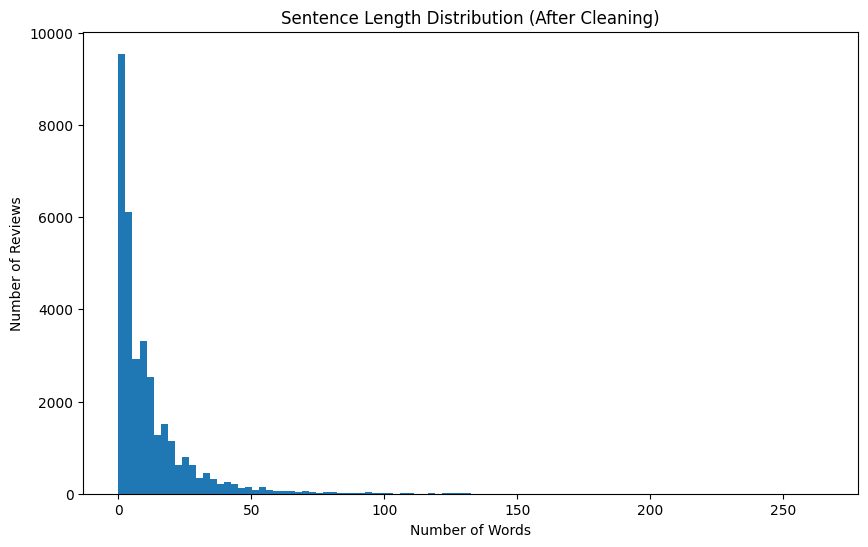

In [17]:
# Update the 'text_length' column with the new lengths after cleaning
data['text_length'] = data['review'].apply(lambda x: len(x.split()))

# Plot the updated sentence length distribution
plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=100)
plt.title('Sentence Length Distribution (After Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.show()

In [18]:
# Calculate the minimum and maximum word count in the 'review' column
min_word_count = data['review'].apply(lambda x: len(x.split())).min()
max_word_count = data['review'].apply(lambda x: len(x.split())).max()
print(f"Minimum word count in 'review' column: {min_word_count}")
print(f"Maximum word count in 'review' column: {max_word_count}")

# Count how many reviews have 0 word count
zero_word_count_reviews = data['review'].apply(lambda x: len(x.split()) == 0).sum()
print(f"Number of reviews with 0 word count: {zero_word_count_reviews}")

Minimum word count in 'review' column: 0
Maximum word count in 'review' column: 265
Number of reviews with 0 word count: 193


#### Tokenization of Review Text

In [19]:
# Define maximum number of words to consider as features
max_features = num_unique_words_after_cleaning

# Load the data
tokenizer = Tokenizer(num_words=max_features)

# Fit the tokenizer on the text
tokenizer.fit_on_texts(list(data['review']))

# Transform the text to sequences
sequences = tokenizer.texts_to_sequences(data['review'])

#### Padding

In [20]:
# Cut texts after this number of words
# (among top max_features most common words)
maxlen = max_word_count

# Pad the sequences
X = pad_sequences(sequences, maxlen=maxlen)

# Define the labels
Y = data['rating'].values

### Geographical Distribution
Plot the geographical distribution of the stores, with colors indicating ratings.Now we can analyze this information to gain insights about the distribution of McDonald's stores based on their ratings.

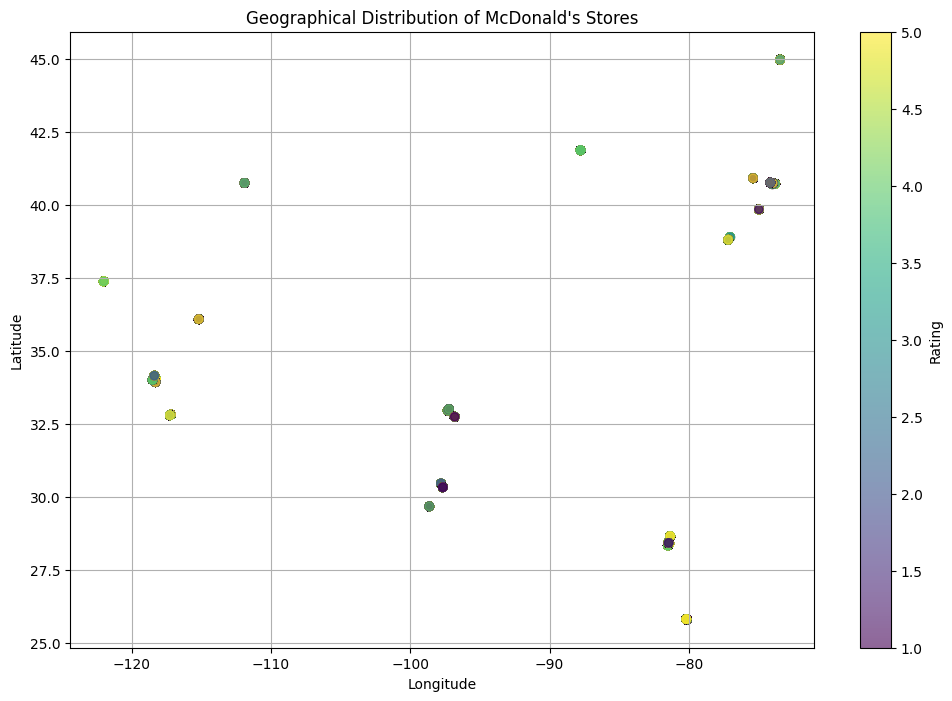

In [21]:
# Plot the geographical distribution of the stores
plt.figure(figsize=(12, 8))
plt.scatter(data['longitude'], data['latitude'], c=data['rating'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Rating')
plt.title('Geographical Distribution of McDonald\'s Stores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

Lets make sure that the store_address feature is perfectly correlated with the 'longitude' and 'latitude' features so that I can justify removing them from the dataset to simply the dataset.

In [22]:
# Combine longitude and latitude into a single feature
data['geo_location'] = data.apply(lambda row: f"{row['longitude']}_{row['latitude']}", axis=1)

# Encode the 'store_address' using label encoding
le = LabelEncoder()
data['store_code'] = le.fit_transform(data['store_address'])

# Create a mapping between the combined longitude-latitude feature and the encoded 'store_address'
location_mapping = data.groupby('geo_location')['store_code'].nunique().reset_index()

# Check if any geo_location corresponds to more than one encoded store address
non_unique_mappings = location_mapping[location_mapping['store_code'] > 1]

if non_unique_mappings.empty:
    print("Every unique combination of longitude and latitude corresponds to a unique store address.")
    # Remove useless, patternless, or redundant features from the dataset
    data = data.drop(columns=['longitude', 'latitude', 'store_address', 'geo_location'])
    print(data.head())
else:
    print("Some combinations of longitude and latitude correspond to more than one store address:")
    print(non_unique_mappings)

Every unique combination of longitude and latitude corresponds to a unique store address.
   reviewer_id   review_time  \
0            1  3 months ago   
1            2    5 days ago   
2            3    5 days ago   
3            4   a month ago   
4            5  2 months ago   

                                              review  rating  text_length  \
0  look like someone spit food normal transaction...       1           22   
1  itd mcdonalds far food atmosphere staff make d...       4           19   
2  made mobile order got speaker checked line mov...       1           33   
3  crispy chicken sandwich ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï...       5            7   
4  repeat order times drive thru still manage mes...       1           31   

   store_code  
0           8  
1           8  
2           8  
3           8  
4           8  


### Temporal Analysis
Reveal insights into how trends change over time.

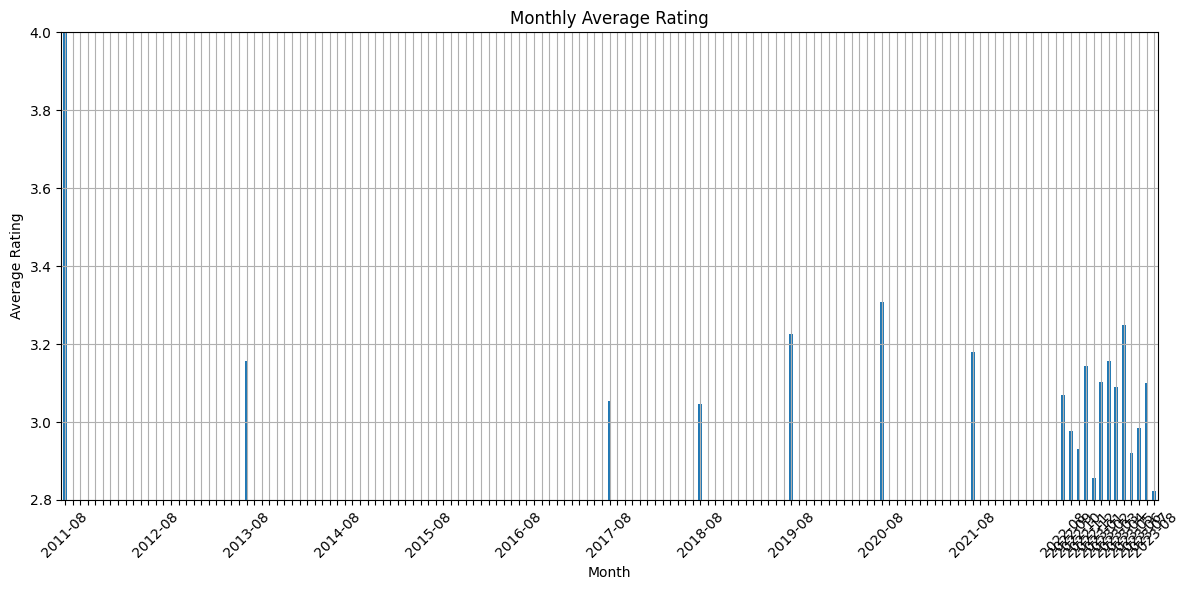

In [23]:
def parse_relative_time(time_str):
    time_str = time_str.lower().replace('a ', '1 ')  # Replacing 'a' with '1' to handle cases like "a month ago"
    today = pd.Timestamp.today()

    match = re.match(r'(\d+) (year|month|week|day|hour|minute|second)s? ago', time_str)
    if match:
        quantity, unit = match.groups()
        quantity = int(quantity)

        delta_args = {unit + 's': quantity} # Constructing the argument for relativedelta dynamically
        return today - relativedelta(**delta_args)

    print(f"ERROR: Unmatched time string: {time_str}")  # Print the unmatched string
    return None

# Applying the custom parsing function to the 'review_time' column
data['parsed_time'] = data['review_time'].apply(parse_relative_time)

# Resampling the data by month and calculating the mean rating for each month
monthly_avg_rating = data.resample('M', on='parsed_time')['rating'].mean()

# Determine which ticks should be labeled
labelled_ticks = [index.strftime('%Y-%m') if not pd.isna(value) else '' for index, value in monthly_avg_rating.items()]
plt.figure(figsize=(12, 6))
monthly_avg_rating.plot(kind='bar')
plt.title('Monthly Average Rating')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.ylim(2.8, 4.0) # Adjusted to include the entire range of y values
plt.xticks(range(len(labelled_ticks)), labelled_ticks, rotation=45) # Apply custom tick labels
plt.grid(True)
plt.tight_layout() # Ensure labels fit within the figure
plt.show()

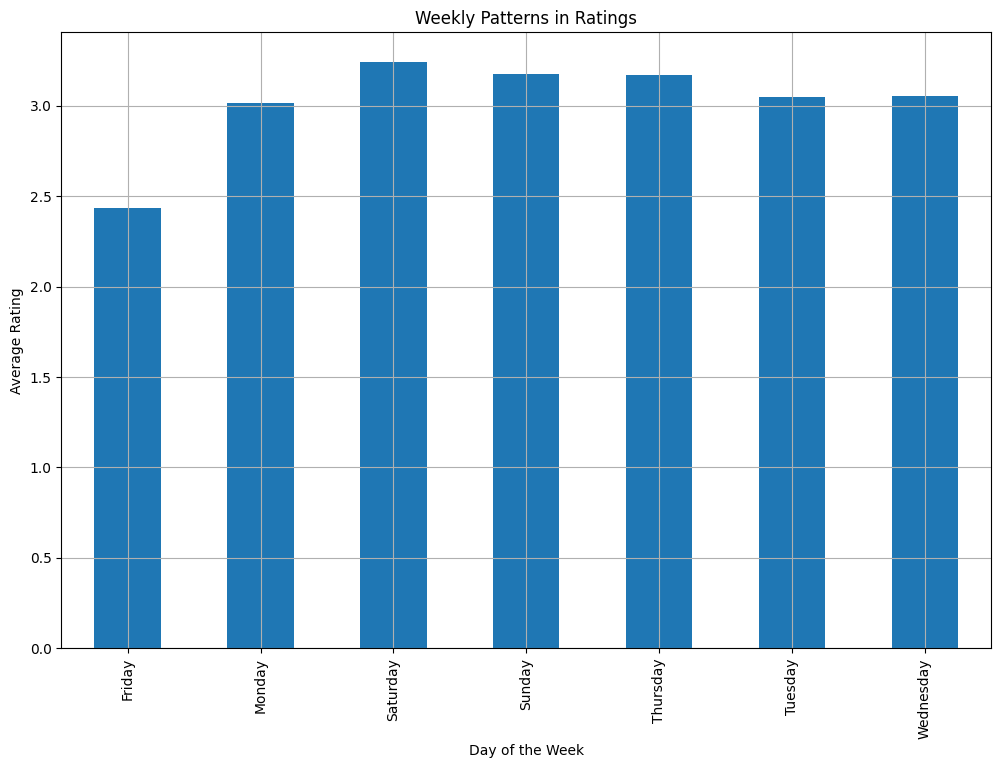

In [24]:
# Add a new column for the day of the week
data['day_of_week'] = data['parsed_time'].dt.day_name()

# Group by day of the week and calculate the average rating
weekly_pattern = data.groupby('day_of_week')['rating'].mean()
weekly_pattern.plot(kind='bar', figsize=(12, 8))
plt.title('Weekly Patterns in Ratings')
plt.xlabel('Day of the Week')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

I'm not seeing any reliable patterns in the review_time feature. I Will remove this during cleaning. Give me code that removes the review_time and day_of_week columns.

In [25]:
# Remove useless, patternless, or redundant features from the dataset
data = data.drop(columns=['review_time', 'parsed_time', 'day_of_week'])
print(data.head())

   reviewer_id                                             review  rating  \
0            1  look like someone spit food normal transaction...       1   
1            2  itd mcdonalds far food atmosphere staff make d...       4   
2            3  made mobile order got speaker checked line mov...       1   
3            4  crispy chicken sandwich ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï...       5   
4            5  repeat order times drive thru still manage mes...       1   

   text_length  store_code  
0           22           8  
1           19           8  
2           33           8  
3            7           8  
4           31           8  


In [26]:
# Count of unique values in each column
for column in data.columns:
    print(f"{column}: {data[column].nunique()} unique values")

reviewer_id: 33396 unique values
review: 21180 unique values
rating: 5 unique values
text_length: 162 unique values
store_code: 40 unique values


#### Feature Correlation Analysis

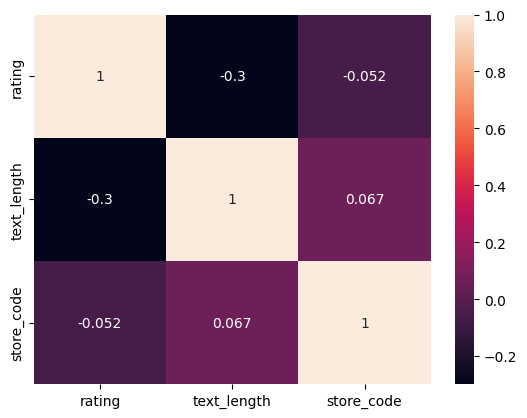

In [27]:
# Select relevant columns for the plot
cols_to_plot = ['rating', 'text_length', 'store_code']
correlation_matrix = data[cols_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

- **rating and text_length:** A negative correlation of approximately -0.299 means that as the rating increases, the text length of the review tends to decrease, and vice versa. It could indicate that customers tend to write longer reviews when they are dissatisfied.

- **rating and store_code:** A slight negative correlation of approximately -0.052 is close to zero and may not signify a strong relationship between the rating and the specific store. It might mean that the store's code doesn't have a significant impact on the rating.

- **text_length and store_code:** A slight positive correlation of approximately 0.067 is also close to zero, suggesting that there's no strong relationship between the text length of the review and the specific store.

The most noticeable relationship here is between rating and text_length, while the relationships with store_code appear to be very weak. None of them seem to correlate strong enough to matter.

### Summary of EDA
During the exploratory data analysis (EDA) of the dataset, various features were examined including rating, text length, and store code. However, no strong correlations were found among these features across different rating levels (from 1 to 5). This lack of significant relationships led to the decision to focus solely on the review text for constructing the Recurrent Neural Network (RNN) model. The 'review' text encapsulates rich customer sentiment, providing the key insights needed for prediction, while other features like text length and store code were determined to not add significant value. This focused approach keeps the model simple and efficient, leveraging the essential information contained in the review text.

## Pre-processing - <span style="font-size: 60%;">(That hasn't already been performed naturally during EDA & Cleaning)</span>

In [28]:
# Adjust the target values to be from 0 to 4
Y = data['rating'].values - 1

# Splitting the data into training and testing sets (adjust this as needed)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_features, 300)) # Word2Vec has 300 dimensions
for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

## Model Training & Testing

In [30]:
# Define the model
#model = Sequential()

# Layers:
#model.add(Embedding(max_features,
 #                   300,  # Dimensionality of the Word2Vec embeddings
 #                   weights=[embedding_matrix],
 #                   input_length=maxlen,
 #                   trainable=False)) # Set trainable=False to prevent the weights from being updated during training
#model.add(Dropout(0.4))                                        # Slightly reduced Dropout layer
#model.add(GRU(64, return_sequences=True,                      # Increased neurons to 64 and added return_sequences=True
#              kernel_regularizer=regularizers.l2(0.005)))     # Reduced L2 regularization
#model.add(Dropout(0.4))                                        # Slightly reduced Dropout layer
#model.add(GRU(32, kernel_regularizer=regularizers.l2(0.005))) # Additional GRU layer
#model.add(Dropout(0.4))                                        # Slightly reduced Dropout layer
#model.add(Dense(5, activation='softmax'))                      # Dense layer with 5 neurons

# Compile the model
#model.compile(loss='sparse_categorical_crossentropy',
 #             optimizer='adam',
 #             metrics=['accuracy'])

# Create the learning rate reduction and early stopping strategies
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
#early_stopping = EarlyStopping(monitor='val_loss', patience=7, min_delta=0.001)

# Train the model with increased batch size
#history = model.fit(X_train, y_train,
#                    batch_size=64,   # Increased batch size
#                    epochs=100,      # Increase epochs as EarlyStopping will stop training when necessary
#                    validation_split=0.2,
#                    callbacks=[reduce_lr, early_stopping])

In [31]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(max_features, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.05)))
    model.add(GRU(hp.Int('neurons_gru1', min_value=32, max_value=128, step=16), return_sequences=True,
                  kernel_regularizer=regularizers.l2(hp.Float('regularization1', min_value=1e-4, max_value=1e-2, sampling='LOG'))))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.05)))
    model.add(GRU(hp.Int('neurons_gru2', min_value=32, max_value=64, step=16),
                  kernel_regularizer=regularizers.l2(hp.Float('regularization2', min_value=1e-4, max_value=1e-2, sampling='LOG'))))
    model.add(Dropout(hp.Float('dropout3', min_value=0.2, max_value=0.5, step=0.05)))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  metrics=['accuracy'])

    return model

tuner = Hyperband(build_model, objective='val_loss', max_epochs=30, factor=3, hyperband_iterations=2, directory='hyperband', project_name='tuning')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, min_delta=0.001)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/DeepLearningFinal_McDonaldsReviews/best_model.h5', save_best_only=True, monitor='val_loss')

tuner.search(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 180 Complete [00h 02m 13s]
val_loss: 0.9758038520812988

Best val_loss So Far: 0.9259669780731201
Total elapsed time: 02h 10m 52s


In [35]:
best_model_path = '/content/drive/My Drive/Colab Notebooks/DeepLearningFinal_McDonaldsReviews/best_model.h5'
best_model = load_model(best_model_path)

## Results

209/209 [==============================] - 2s 8ms/step


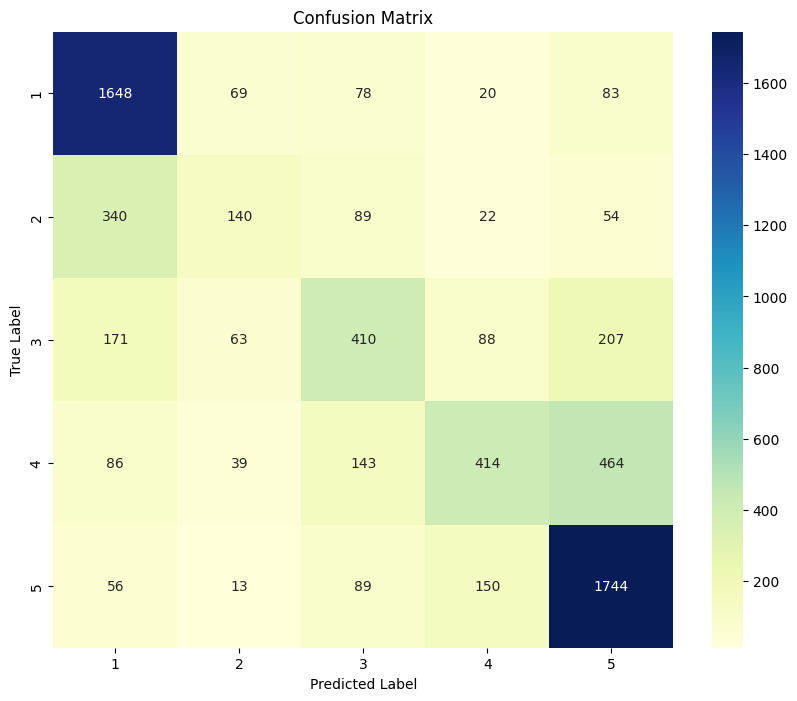

              precision    recall  f1-score   support

           1       0.72      0.87      0.78      1898
           2       0.43      0.22      0.29       645
           3       0.51      0.44      0.47       939
           4       0.60      0.36      0.45      1146
           5       0.68      0.85      0.76      2052

    accuracy                           0.65      6680
   macro avg       0.59      0.55      0.55      6680
weighted avg       0.63      0.65      0.63      6680



In [36]:
# Predict the values from the validation dataset
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert validation observations to one hot vectors
y_true = y_test

# Add 1 to both the predicted and true classes to represent target values from 1 to 5
y_pred_classes += 1
y_true += 1

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(5) + 0.5, labels=[1, 2, 3, 4, 5]) # Label x-axis with 1 to 5
plt.yticks(ticks=np.arange(5) + 0.5, labels=[1, 2, 3, 4, 5]) # Label y-axis with 1 to 5
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

## Analysis of Results

### Results
The model achieved an accuracy of 65% on the test dataset. The precision, recall, and F1-score for the individual classes (1 to 5) varied, indicating that the model had different levels of success in classifying the various categories.

From the confusion matrix, we can observe that:
- The model performed best at classifying class 1 and class 5, with high true positive rates.
- Class 2 and class 4 had a lower recall, meaning a higher proportion of false negatives. Particularly for class 2, the model struggled, with a precision of 0.43 and recall of only 0.22.
- There was a significant misclassification between classes 4 and 5, and classes 3 and 5, indicating possible confusion in distinguishing between these categories.

### Summary and Process
The objective of the project was to build a model to classify McDonald's reviews into five different categories. The architecture involved the use of embeddings, GRUs (Gated Recurrent Units), dropout layers, and dense layers. Hyperparameters were tuned using Hyperband optimization, aiming to minimize the validation loss.

The selected hyperparameters for tuning included:
- Dropout rates in different layers to prevent overfitting
- Number of neurons in GRU layers to control the model's complexity
- Regularization terms for the GRUs to prevent overfitting
- Learning rate for the Adam optimizer to control the speed of convergence

### Why the Hyperparameters?
The hyperparameters were chosen to provide a balance between model complexity and the ability to generalize to unseen data. By fine-tuning dropout rates, neuron numbers in GRU layers, and regularization terms, the model was guided to learn the essential patterns without memorizing noise. Learning rate tuning ensured that the model was able to converge optimally without overshooting or getting stuck in local minima.

## Conclusion

Through this project, the power of deep learning in natural language processing and the importance of hyperparameter tuning were demonstrated. The use of Hyperband for hyperparameter optimization proved effective, but the results also highlighted areas that could be further improved, particularly in distinguishing between certain classes.

The lessons learned include the significance of data preprocessing, the choice of appropriate model architecture, and the careful selection of hyperparameters. The ability to visually interpret results through confusion matrices and classification reports also provided valuable insights into model behavior. Overall, this project achieved success in applying deep learning techniques to a real-world problem, providing valuable experience and knowledge that can be applied to future endeavors.